In [1]:
# ! pip install --upgrade pytorch-lightning einops

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.set_float32_matmul_precision('medium')

import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping

from torch.utils.data import TensorDataset, DataLoader, random_split
from einops import rearrange

In [16]:
import sys
sys.path.append("../")

from simulators.conjugate import MultivariateNormalConjugatePrior

In [2]:
from matplotlib import cm
cmap = cm.get_cmap('viridis_r')

import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

import logging
import matplotlib

logging.getLogger('matplotlib').setLevel(logging.ERROR)

## Make data

In [174]:
dim = 3  # Number of dimensions per sample
n = 5  # How many samples

n_train = 50000
seq_length = 200

# Prior
mu0, Sigma0 = np.zeros(dim), 3. ** 2 * np.diag(np.ones(dim))  

mu_list = sps.norm(loc=0., scale=3.).rvs((n_train, dim))
Sigma = 2 * np.diag(np.arange(1, dim + 1))

In [21]:
x = np.array([sps.multivariate_normal(mu, Sigma).rvs((seq_length, n)) for mu in mu_list])
x = x.reshape(n_train, seq_length, n, dim)

In [176]:
prior = MultivariateNormalConjugatePrior(mu0, Sigma0, Sigma)
for x_i in x[0]:
    prior.update(x_i)

In [177]:
data = torch.Tensor(rearrange(x, "n_train seq_length n dim -> n_train seq_length (dim n)"))

targets = torch.Tensor(mu_list)

val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(data))

dataset = TensorDataset(data, targets)

dataset_train, dataset_val = random_split(dataset, [len(data) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

In [24]:
data.shape

torch.Size([20000, 100, 10])

## Deep Set

In [178]:
from models.deep_set import DeepSetPL

In [179]:
max_epochs = 50
sum_aggregations = True
model = DeepSetPL(n_in=int(dim * n), n_out=int(2 * dim), n_embedding=256, max_epochs=max_epochs, seq_length=seq_length, sum_aggregations=sum_aggregations)

In [180]:
# Lightning callbacks
checkpoint_callback = ModelCheckpoint(monitor="val_loss", filename="{epoch:02d}-{val_loss:.2f}", every_n_epochs=3, save_top_k=1)
early_stop_callback = EarlyStopping(monitor='val_loss', patience=6)        

trainer = pl.Trainer(max_epochs=max_epochs, accelerator='gpu', devices=1, callbacks=[checkpoint_callback,early_stop_callback])
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | net  | DeepSet | 1.5 M 
---------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.073     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 9: 100%|██████████| 157/157 [00:06<00:00, 24.07it/s, loss=-0.951, v_num=252]


In [181]:
model.to('cpu').eval();

In [182]:
from einops import rearrange

def get(N):
    xx = model.net.enc(rearrange(data_test[:, :N, :], "batch n_set n_feat -> (batch n_set) n_feat", n_set=N))
    xx = rearrange(xx, "(batch n_set) n_out -> batch n_set n_out", n_set=N)
    if not sum_aggregations:
        xx = torch.cat([xx.mean(-2), (N * torch.ones(n_test)[:, None])], -1)
    else:
        xx = xx.sum(-2)
    return model.net.dec(xx).to('cpu')

In [183]:
out = [get(N).detach().numpy() for N in range(1, model.seq_length + 1)]
out = torch.Tensor(out)

In [184]:
out = rearrange(out, 'a b c -> b a c')

In [185]:
seq_length_test = seq_length

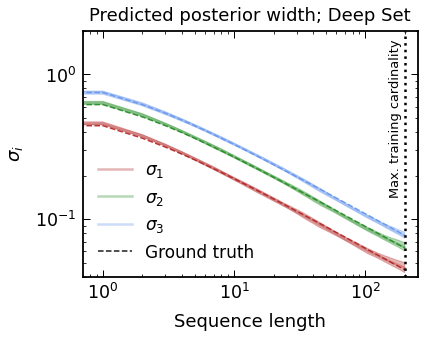

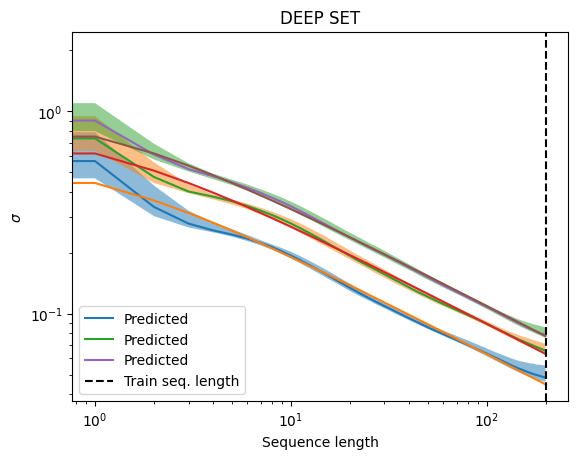

In [188]:
for idx in range(dim):
    
    mu, log_sigma = torch.chunk(out, 2, -1)
    sigma = log_sigma.exp()

    sigma = sigma[..., idx]
    mu = mu[..., idx]

    plt.plot(np.arange(seq_length_test), np.median(sigma.detach().numpy(), axis=0), label=r"$\sigma_{}$".format(idx + 1), color=colors[idx], alpha=0.33)
    plt.fill_between(np.arange(seq_length_test), np.percentile(sigma.detach().numpy(), 16, axis=0), np.percentile(sigma.detach().numpy(), 84, axis=0), alpha=0.33, color=colors[idx])
    plt.plot(np.arange(seq_length_test), np.array(np.sqrt(prior.Sigma_list))[1:, idx, idx], color=colors[idx], ls='--', lw=1.5)
    
plt.plot([0.], [0.], label="Ground truth", color='k', ls='--', lw=1.5)

    plt.plot(np.arange(seq_length_test), np.array(np.sqrt(prior.Sigma_list))[1:, idx, idx])

plt.axvline(seq_length, ls='--', color='k', label="Train seq. length")
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.7, 250)
plt.ylim(0.04, 2)
plt.xlabel("Sequence length", fontsize=fontsize)
plt.ylabel(r"$\sigma_i$", fontsize=fontsize)
plt.title("Predicted posterior width; Deep Set", fontsize=fontsize, y=1.01)
plt.legend(loc='lower left')

plt.tight_layout()
plt.savefig("../paper/figs/post_std_deepset.pdf")

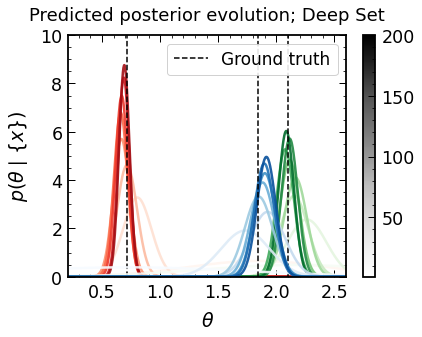

In [65]:
from scipy.stats import norm
import matplotlib.cm as cm
from matplotlib.colors import Normalize

plt.figure(figsize=(6, 4.8))

mu, log_sigma = torch.chunk(out, 2, -1)
sigma = log_sigma.exp()

idx_sample = 2
x_lin = np.linspace(np.min(mu_list_test[idx_sample, :]) - 0.5, np.max(mu_list_test[idx_sample, :]) + 0.5, 1000)

cmaps = [cm.get_cmap('Reds'), cm.get_cmap('Greens'), cm.get_cmap('Blues')]

for idx in range(dim):
    for i_seq in np.arange(0, seq_length_test, 25):
        plt.plot(x_lin, norm.pdf(x_lin, mu[idx_sample, i_seq, idx], sigma[idx_sample, i_seq, idx]), color=cmaps[idx](i_seq / seq_length_test))
    plt.axvline(mu_list_test[idx_sample, idx], ls='--', color='k', label="Ground truth" if idx == 0 else None, lw=1.5)

cmap = cm.get_cmap('Greys')  # Using Greys colormap for the colorbar
norm = Normalize(vmin=1, vmax=seq_length_test)  # Normalize the colormap from 1 to seq_length_test
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.colorbar(sm)

plt.xlabel(r"$\theta$")
plt.ylabel(r"$p\left(\theta\mid \{x\}\right)$")
plt.xlim(np.min(mu_list_test[idx_sample, :]) - 0.5, np.max(mu_list_test[idx_sample, :]) + 0.5)
plt.title("Predicted posterior evolution; Deep Set", fontsize=fontsize, y=1.03)
plt.legend(loc='upper right', fancybox=True, frameon=True, framealpha=0.89)
plt.ylim(0, 10)


plt.tight_layout()
plt.savefig("../paper/figs/post_deepset.pdf")

# Deep set own

In [25]:
from models.utils import build_mlp
import pytorch_lightning as pl
import torch.distributions as dist

class DeepSetOwn(pl.LightningModule):

    def __init__(self, optimizer = torch.optim.AdamW, optimizer_kwargs = {"weight_decay": 1e-4}, lr = 1e-3,
                 max_epochs = 10, input_dim = 1, embedding_dim = 256, hidden_dim = 128, layers = 4):
        super().__init__()

        self.max_epochs = max_epochs
        self.optimizer = optimizer
        self.lr = lr
        self.optimizer_kwargs = optimizer_kwargs

        self.enc = build_mlp(input_dim = input_dim, output_dim = embedding_dim, 
                                hidden_dim = hidden_dim, layers = layers)
        self.dec = build_mlp(input_dim = embedding_dim, output_dim = 2,
                                hidden_dim = hidden_dim, layers = layers)

    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), lr = self.lr, **self.optimizer_kwargs)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = self.max_epochs)
        return {"optimizer": optimizer, 
                "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "val_loss",
                "frequency": 1}
                }

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred_mu, pred_sigma = self.forward(x)
        loss = -dist.Normal(pred_mu, pred_sigma).log_prob(y).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred_mu, pred_sigma = self.forward(x)
        loss = -dist.Normal(pred_mu, pred_sigma).log_prob(y).mean()
        self.log("val_loss", loss)
        return loss

    def forward(self, x):
        embedding = torch.nn.Softmax(dim = 1)(self.enc.forward(x).mean(-2))
        pred = self.dec(embedding)
        pred_mu, pred_log_sigma = torch.chunk(pred, 2, -1)
        pred_sigma = pred_log_sigma.exp()
        return pred_mu, pred_sigma


In [38]:
max_epochs = 10
model_dso = DeepSetOwn(max_epochs = max_epochs)

In [39]:
early_stop_callback = EarlyStopping(monitor = 'val_loss', patience = 6)
checkpoint_callback = ModelCheckpoint(monitor = "val_loss", filename = "{epoch:02d}-{val_loss:.2f}", 
                                        every_n_epochs = 1, save_top_k = 1)
trainer = pl.Trainer(max_epochs = max_epochs, accelerator = 'mps', devices = 1, callbacks = [early_stop_callback, checkpoint_callback])
trainer.fit(model = model_dso, train_dataloaders = train_loader, val_dataloaders = val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | enc  | Sequential | 99.3 K
1 | dec  | Sequential | 99.2 K
------------------------------------
198 K     Trainable params
0         Non-trainable params
198 K     Total params
0.794     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 157/157 [00:06<00:00, 25.68it/s, loss=0.148, v_num=248]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 157/157 [00:06<00:00, 25.56it/s, loss=0.148, v_num=248]


In [41]:
mu, sigma = model_dso.forward(data)

In [45]:
np.median(sigma.detach().numpy())

0.2873798

### LSTM

In [69]:
# from models.sequential import LSTMRandomMaskingPL
# from pytorch_lightning.callbacks import TQDMProgressBar

In [70]:
# max_epochs = 50
# model = LSTMRandomMaskingPL(n_in=int(dim * n), n_out=int(2 * dim), max_epochs=max_epochs, seq_length=seq_length)

In [71]:
# # Lightning callbacks
# checkpoint_callback = ModelCheckpoint(monitor="val_loss", filename="{epoch:02d}-{val_loss:.2f}", every_n_epochs=3, save_top_k=1)
# early_stop_callback = EarlyStopping(monitor='val_loss', patience=6)  
# progress = TQDMProgressBar()

# trainer = pl.Trainer(max_epochs=max_epochs, accelerator='gpu', devices=1, callbacks=[checkpoint_callback,early_stop_callback, progress])
# trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [72]:
# # model.load_from_checkpoint(checkpoint_callback.best_model_path, max_epochs=max_epochs);
# model.eval();
# model = model.to('cpu')

In [73]:
# out = model.net(data_test[:])
# mu, log_sigma = torch.chunk(out, 2, -1)

In [74]:
# seq_length_test = seq_length

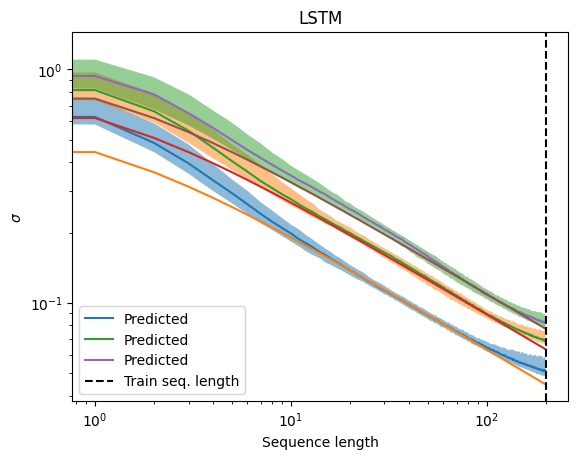

In [75]:
# colors = ['firebrick', 'forestgreen', 'cornflowerblue']

# plt.figure(figsize=(6, 4.8))

# for idx in range(dim):
    
#     mu, log_sigma = torch.chunk(out, 2, -1)
#     sigma = log_sigma.exp()

#     sigma = sigma[..., idx]
#     mu = mu[..., idx]

#     plt.plot(np.arange(seq_length_test), np.median(sigma.detach().numpy(), axis=0), label=r"$\sigma_{}$".format(idx + 1), color=colors[idx])
#     plt.fill_between(np.arange(seq_length_test), np.percentile(sigma.detach().numpy(), 16, axis=0), np.percentile(sigma.detach().numpy(), 84, axis=0), alpha=0.33, color=colors[idx])
#     plt.plot(np.arange(seq_length_test), np.array(np.sqrt(prior.Sigma_list))[1:, idx, idx], color=colors[idx], ls='--')

# plt.text(190, 0.5, "Max. training cardinality", rotation=90, horizontalalignment='right', verticalalignment='center')
# plt.axvline(seq_length, ls=':', color='k', label="Groud truth")
# plt.xscale("log")
# plt.yscale("log")
# plt.xlim(0.7, 250)
# plt.ylim(0.04, 5)
# plt.xlabel("Sequence length")
# plt.ylabel(r"$\sigma_i$")
# plt.title("Predicted posterior width; LSTM")
# plt.legend(loc='lower left')

# plt.tight_layout()
# plt.savefig("../paper/figs/post_std_lstm.pdf")

## Transformer

In [51]:
from models.transformer import TransformerUpdateNetPL

In [52]:
max_epochs = 50
model = TransformerUpdateNetPL(n_in=int(dim * n), n_out=int(2 * dim), max_epochs=max_epochs, seq_length=seq_length)

In [53]:
# Lightning callbacks
checkpoint_callback = ModelCheckpoint(monitor="val_loss", filename="{epoch:02d}-{val_loss:.2f}", every_n_epochs=3, save_top_k=1)
early_stop_callback = EarlyStopping(monitor='val_loss', patience=6)        

trainer = pl.Trainer(max_epochs=max_epochs, accelerator='gpu', devices=1, callbacks=[checkpoint_callback,early_stop_callback])
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                 | Params
----------------------------------------------
0 | net  | TransformerUpdateNet | 6.3 M 
----------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.304    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [54]:
# model.load_from_checkpoint(checkpoint_callback.best_model_path, n_in=int(dim * n), n_out=int(2 * dim), max_epochs=max_epochs, seq_length=seq_length);
model.eval();

In [55]:
out = model.to('cuda').net(data_test[:].to('cuda')).to('cpu')
mu, log_sigma = torch.chunk(out, 2, -1)

In [56]:
seq_length_test = seq_length

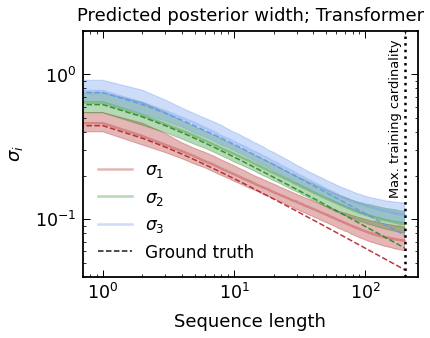

In [57]:
colors = ['firebrick', 'forestgreen', 'cornflowerblue']

plt.figure(figsize=(6, 4.8))
fontsize = 18
for idx in range(dim):
    
    mu, log_sigma = torch.chunk(out, 2, -1)
    sigma = log_sigma.exp()

    sigma = sigma[..., idx]
    mu = mu[..., idx]

    plt.plot(np.arange(seq_length_test), np.median(sigma.detach().numpy(), axis=0), label=r"$\sigma_{}$".format(idx + 1), color=colors[idx], alpha=0.33)
    plt.fill_between(np.arange(seq_length_test), np.percentile(sigma.detach().numpy(), 16, axis=0), np.percentile(sigma.detach().numpy(), 84, axis=0), alpha=0.33, color=colors[idx])
    plt.plot(np.arange(seq_length_test), np.array(np.sqrt(prior.Sigma_list))[1:, idx, idx], color=colors[idx], ls='--', lw=1.5)
    
plt.plot([0.], [0.], label="Ground truth", color='k', ls='--', lw=1.5)

plt.text(190, 0.5, "Max. training cardinality", rotation=90, horizontalalignment='right', verticalalignment='center', fontsize=13)
plt.axvline(seq_length, ls=':', color='k')
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.7, 250)
plt.ylim(0.04, 2)
plt.xlabel("Sequence length", fontsize=fontsize)
plt.ylabel(r"$\sigma_i$", fontsize=fontsize)
plt.title("Predicted posterior width; Transformer", fontsize=fontsize, y=1.01)
plt.legend(loc='lower left')

plt.tight_layout()
# plt.savefig("../paper/figs/post_std_transformer.pdf")